# 第5章 Pythonを使った人工知能の前処理を学ぶ

## 5.1 はじめに

臨床での開発や研究が盛んにおこなわれていない。
臨床施設は画像データを含む多くの医療データを所有している。
SVNにはスケール変換が必要なことは有名。

---

## 5.2 テーブルデータにおける欠損値の取り扱い

### 5.2.1 テーブルデータの読み込み


リスト5.2.2 pandasを用いたcsvファイルの読み込みと表示

In [1]:
import pandas as pd
# コンマ区切りでcsvファイルを読み込み、性別を0, 1に置き換える。
df = pd.read_csv(
    "/Users/toku/Documents/Progects/カルー勉強会/"+
    "titanic/train.csv", sep=",").replace("male", 0).replace("female", 1)

print(df)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name  Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    0  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0      1   
2                               Heikkinen, Miss. Laina    1  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0      1   
4                             Allen, Mr. William Henry    0  35.0      0   
..                                                 ...  ...   ...    ...   
886        

### 5.2.2 欠損値の処理

データの欠損３種類:
1. MCAR(missing completely at random)  
    完全にランダムな原因で欠損が発生
1. MAR (missing at random)  
    観測データに依存する原因で欠損が発生
1. MNAR(missing not at random)
    欠損値そのものに原因して欠損が発生

対処法:
1. 完全ケース分析  
    欠損値を含むサンプルを除外
1. 欠損値を補完

しかし、MARやMNARを多く含むデータセットの場合は、完全ケース分析を行うと、
解析結果に大きな歪みを生じてしまう。

欠損値に何らかの値を代入する方法として平均値代入法、回帰代入法などがある。
単純だが、学習う結果に基づく推定の際に、大きな誤差を生みかねない。
近年では、多重代入法が考案されている。

以降では、欠損値をもつデータを削除するリストワイズ削除処理と、シンプルな
欠損値補完を行う。

リスト5.2.3 データセット内のクラス別欠損値数表示

In [18]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

欠損値を処理するメソッド:
    1. dropna(): データ欠損のある行または列を削除
    1. fillna(): データ欠損のある要素を補完する

リスト5.2.4 データセットに対するリストワイズ処理

In [2]:
df_listwise = df.dropna()
df_listwise.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

リスト5.2.5 データセットのデータを確認

In [3]:
print(df_listwise['Age'])

1      38.0
3      35.0
6      54.0
10      4.0
11     58.0
       ... 
871    47.0
872    33.0
879    56.0
887    19.0
889    26.0
Name: Age, Length: 183, dtype: float64


データ数の減少より、推定自体の悪化が予想される。

次に、平均値代入法を適用する。これは、単一代入法の一つである。代入モデルという欠損値を予測するモデルを作成し、作成されたモデルによって欠損値を補う。

リスト5.2.6 平均値代入法

In [4]:
df_mean = df.copy(deep=False) 
df_mean['Age'] = df_mean['Age'].fillna(df_mean['Age'].mean())
df_mean.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

リスト5.2.7  Age列を確認

In [5]:
print(df_mean['Age'])

0      22.000000
1      38.000000
2      26.000000
3      35.000000
4      35.000000
         ...    
886    27.000000
887    19.000000
888    29.699118
889    26.000000
890    32.000000
Name: Age, Length: 891, dtype: float64


推定誤差の評価ができない

### 5.2.3 欠損値処理が機械学習に及ぼす効果

In [8]:
# ライブラリのインポート
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from pandas.plotting import scatter_matrix

リスト5.2.9 分類するクラスを確認(リストワイズ処理後のデータを使用

In [10]:
df_listwise['Survived'].value_counts()

1    123
0     60
Name: Survived, dtype: int64

ここから、学習に不要なクラスを削除して、学習用の説明変数と正解クラス、
評価用の説明変数と評価クラスにデータセットを分割する。

ここでは、タイタニック号事故の生存者と死者の２クラス分類の予測を行う。

リスト5.2.10 データセットの成型と学習のための分割

[train_test_splitの説明](https://note.nkmk.me/python-sklearn-train-test-split/)

In [41]:
# 不要なクラスを削除
df2 = df_listwise.drop(["Name", "SibSp", "Parch", "Ticket", "Cabin", "Embarked"], axis=1)

train_dataset = df2.values
train_x = train_dataset[:, 2:] # Survived以降の変数
train_y = train_dataset[:, 1]  # 正解クラス(Survived)

# 訓練用の説明変数と正解クラス、評価用の説明変数と正解クラスに分割
(train_x, test_x, train_y, test_y) = train_test_split(train_x, train_y, test_size = 0.3, random_state = 0)

ROC曲線 あるがある確率,ないがない確率がそれぞれ１に近づくと良い。

リスト5.2.11 ランダムフォレストの実行

各決定きのふかさ３、
決定きの数１００  
精度とROCを
描画

In [52]:
# 識別モデルの構築(ランダムフォレスト)
forest = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=0)

# 学習させます
forest = forest.fit(train_x, train_y)

# 予測値の算出
y_pred = forest.predict(test_x)

# モデル学習きのモデル識別精度
trainaccuracy_random_forest = forest.score(train_x, train_y)
print("TrainAccuracy: {}".format(trainaccuracy_random_forest))

# 評価用データセットでの識別精度
accuracy_random_forest = accuracy_score(test_y, y_pred)
print("Accuracy: {}".format(accuracy_random_forest))

# recallの評価
recall_random_forest =  recall_score(test_y, y_pred)
print("Recall: {}".format(recall_random_forest))

TrainAccuracy: 0.8046875
Accuracy: 0.8181818181818182
Recall: 0.9047619047619048


リスト 5.2.12 ROC曲線の描画

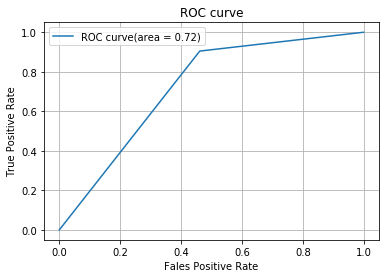

In [53]:
# FPR, TPR, しきい値を算出
fpr, tpr, thresholds = metrics.roc_curve(test_y, y_pred)

# AUC の計算
auc = metrics.auc(fpr, tpr)

# ROC曲線をプロット
plt.plot(fpr, tpr, label = "ROC curve(area = %.2f)"%auc)
plt.legend()
plt.title("ROC curve")
plt.xlabel("Fales Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)